# Principal Component Analysis Outlier Detector (PCA-OD)

----

**Created by**:

- **Author**: Dr. Saad Laouadi
- **Date**: 11/08/2024

This notebook was created by dr. Saad Laouadi on August 11th, 2024 as part of a series on anomaly detection algorithms. The content is designed for researchers, data scientists, and practitioners interested in applying the PCA Outlier Detector algorithm to identify anomalies in a dataset.

**Copyright**

**© 2024 Dr. Saad Laouadi. All rights reserved.**

---

## Table of Contents

## Table of Contents
1. [Objective](#Objective)
2. [Prerequisites](#Prerequisites)
3. [Theoretical Background of PCA Outlier Detector](#Theoretical-Background-of-PCA-Outlier-Detector)
    - [1. Introduction](#1.-Introduction)
4. [4. Core Components](#2-core-components)
   - [4.1 Principal Component Analysis](#21-principal-component-analysis)
   - [4.2 Dimensionality Reduction](#22-dimensionality-reduction)
   - [4.3 Anomaly Score Calculation](#23-anomaly-score-calculation)
   - [4.4 Variants of PCA-OD](#24-variants-of-pca-od)
5. [Theoretical Underpinnings](#3-theoretical-underpinnings)
   - [5.1 Unsupervised Learning Theory](#31-unsupervised-learning-theory)
   - [5.2 Linear Algebra and Eigendecomposition](#32-linear-algebra-and-eigendecomposition)
   - [5.3 Information Theory](#33-information-theory)
6. [Mathematical Framework](#4-mathematical-framework)
   - [6.1 PCA Model](#41-pca-model)
   - [6.2 Reconstruction Error](#42-reconstruction-error)
   - [6.3 Anomaly Score](#43-anomaly-score)
   - [6.4 Anomaly Classification](#44-anomaly-classification)
7. [Computational Complexity](#5-Computational-Complexity)
8. [Using Principal Component Analysis (PCA) for Outlier Detection Using PyOD Framework](#Using-Principal-Component-Analysis-(PCA)-for-Outlier-Detection-Using-PyOD-Framework)
9. [Training Workflow for PCA](#Training-Workflow-for-PCA)
10. [Practical Example of Principal Component Analysis for Outlier Detection (PCA-OD) with Simulated Data](#Practical-Example-of-Principal-Component-Analysis-for-Outlier-Detection-(PCA-OD)-with-Simulated-Data)
11. [Real-World Example](#Real-World-Example)
12. [Training Principal Component Analysis (PCA) for Unsupervised Outlier Detection](#Training-Principal-Component-Analysis-(PCA)-for-Unsupervised-Outlier-Detection)
13. [Fine-Tune PCA Algorithm](#Fine-Tune-PCA-Algorithm)

---

## Objective

The primary objective of this notebook is to provide a comprehensive exploration of the **Principal Component Analysis (PCA) Outlier Detector** algorithm, encompassing its theoretical foundations, practical implementation, and performance evaluation. Specifically, this notebook aims to:

1. **Elucidate the Theoretical Framework**: Present a detailed explanation of the underlying principles of PCA and its application to outlier detection, including the concepts of principal components, variance explanation, and reconstruction error.

2. **Demonstrate Practical Implementation**: Guide readers through the step-by-step process of implementing PCA Outlier Detector using `pyod` library.

3. **Explore Hyperparameter Tuning**: Investigate the impact of various hyperparameters, particularly the number of principal components and the threshold for outlier detection, on the PCA Outlier Detector's performance, providing insights into optimal configuration for different types of datasets.

4. **Analyze Performance**: Evaluate PCA Outlier Detector's effectiveness in identifying outliers using both synthetic and real-world datasets, employing appropriate evaluation metrics and visualization techniques.

5. **Compare with Other Techniques**: Benchmark PCA Outlier Detector against other outlier detection methods to highlight its strengths and potential limitations, especially in handling high-dimensional data.

6. **Discuss Real-World Applications**: Present case studies demonstrating PCA Outlier Detector's applicability in various domains, such as image processing, financial anomaly detection, or identifying unusual patterns in scientific experiments.

7. **Address Challenges and Limitations**: Discuss potential challenges in implementing PCA Outlier Detector, including its sensitivity to scale, the assumption of linearity, and the interpretability of results in high-dimensional spaces.

8. **Explore Extensions and Variants**: Introduce readers to advanced topics related to PCA-based outlier detection, such as Kernel PCA for non-linear relationships and robust PCA for handling contaminated datasets.

By the end of this notebook, readers will have gained a thorough understanding of the PCA Outlier Detector, equipped with the knowledge and practical skills to apply this algorithm effectively in their own anomaly detection tasks across diverse datasets and domains, particularly those involving high-dimensional data.

### Prerequisites

This notebook assumes a foundational understanding of Python tools for data manipulation and processing. The following prerequisites will help you get the most out of this material:

1. **Data Manipulation**:
   - Familiarity with reading and writing data using libraries such as **Pandas** and **NumPy**.

2. **Machine Learning Workflow**:
   - Prior experience with the **Scikit-learn** library, including:
     - Preprocessing techniques like scaling and normalization.
     - Splitting data into training and test sets using tools like `train_test_split`.

3. **Data Visualization**:
   - Proficiency in using plotting libraries such as **Matplotlib** and **Seaborn** for visualizing data and model results.

In [1]:
# ============================================================================================# 
#                                 Environment Setup
#  Here we import all the necessary modules and tools we will use through this notebook
# ============================================================================================# 
import os
import sys
import time

import numpy as np 
import pandas as pd
from scipy.io import arff

from pyod.models.pca import PCA 
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.auto_encoder import AutoEncoder

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

# The utils module is not an installable package, it is the same directory as this notebook
from utils import generate_data, visualize_data, apply_abod, apply_abod_advanced, precision_at_rank_n
from utils import grid_search_abod, hyperopt_objective, plot_outliers_vs_inliers
from utils import preprocess_pipeline

from suod_utils import generate_sample_data, evaluate_model, visualize_results

from pyod.utils.utility import standardizer
from pyod.utils.data import generate_data, get_outliers_inliers, evaluate_print
from pyod.utils.example import visualize

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope

def print_banner(sep, nchar, title):
    print(sep * nchar)
    print(title.center(nchar))
    print(sep * nchar)

# Configuration 
DATA_PATH = "../../datasets/HeartDisease/HeartDisease_withoutdupl_norm_44.arff"

# Theoretical Background of PCA Outlier Detector

## 1. Introduction

Principal Component Analysis Outlier Detector (PCA-OD) is an unsupervised machine learning algorithm designed for detecting anomalies or outliers in complex, high-dimensional datasets. It leverages the dimensionality reduction capabilities of PCA to identify data points that significantly deviate from the main patterns in the data.

PCA-OD operates on the assumption that normal data points lie close to the principal subspace defined by the top principal components, while anomalies are located far from this subspace. By examining the reconstruction error or the distance to the principal subspace, the algorithm can quantify how much a point differs from the main data distribution.

The fundamental premise underlying PCA-OD's effectiveness is rooted in the concept of variance explanation. While normal data points are well-represented by the top principal components, outliers often require additional components to be accurately reconstructed. This difference in representation forms the basis for anomaly identification.

By exploiting this principle, PCA-OD offers a powerful tool for detecting anomalies in high-dimensional spaces where traditional distance-based methods may falter. Its ability to capture global patterns in data makes it particularly suited for datasets with complex correlations across features, from image processing to financial fraud detection.

## 2. Core Components

### 2.1 Principal Component Analysis

The PCA-OD algorithm employs Principal Component Analysis, consisting of:
- Computation of the covariance matrix of the data
- Eigendecomposition of the covariance matrix to find principal components
- Projection of data onto the principal component space

### 2.2 Dimensionality Reduction

PCA performs dimensionality reduction by selecting the top k principal components that explain most of the variance in the data. This step is crucial for filtering out noise and focusing on the most important patterns.

### 2.3 Anomaly Score Calculation

The key idea in PCA-OD is to use the reconstruction error or the distance to the principal subspace as an anomaly score. Normal data points, which are well-represented by the top principal components, will have low anomaly scores. Conversely, anomalies or outliers, being poorly represented, will typically result in higher anomaly scores.

### 2.4 Variants of PCA-OD

Extensions of the basic PCA-OD include Kernel PCA for non-linear relationships and Robust PCA for handling datasets with a high proportion of outliers.

## 3. Theoretical Underpinnings

### 3.1 Unsupervised Learning Theory

PCA-OD operates within the framework of unsupervised learning, where the algorithm learns patterns and structures from data without explicit labels. The theory of unsupervised learning, particularly manifold learning and spectral methods, forms the basis for understanding how PCA-OD can identify anomalies without prior knowledge of what constitutes an anomaly.

### 3.2 Linear Algebra and Eigendecomposition

The concept of eigendecomposition is crucial to PCA-OD. It allows the algorithm to find the directions of maximum variance in the data, which form the basis for the principal subspace.

### 3.3 Information Theory

Information theory provides insights into the compression achieved by PCA. The principal components can be viewed as an efficient coding of the data, with anomalies requiring more information to encode accurately.

## 4. Mathematical Framework

### 4.1 PCA Model

Let X be the data matrix. The PCA transformation can be expressed as:

$$Z = X W$$

where W is the matrix of principal component loadings.

### 4.2 Reconstruction Error

The reconstruction error for a data point x can be calculated as:

$$e(x) = ||x - \hat{x}||^2$$

where $\hat{x} = W_k W_k^T x$ is the reconstruction of x using the top k principal components.

### 4.3 Anomaly Score

The anomaly score S for a data point x can be defined as:

$$S(x) = e(x) = ||x - W_k W_k^T x||^2$$

### 4.4 Anomaly Classification

A threshold τ is often used to classify points as anomalies:

If $S(x) > τ$, x is classified as an anomaly.

## 5. Computational Complexity

The computational complexity of PCA-OD can be divided into two phases:

1. PCA computation: $O(min(n^2p, np^2))$, where n is the number of data points and p is the number of features.

2. Scoring: $O(npk)$, where k is the number of principal components used.

The exact complexity can vary based on the specific implementation and the chosen number of principal components. While the algorithm can be computationally intensive for very high-dimensional datasets, various approximation techniques can be employed to improve performance, making PCA-OD suitable for many real-world anomaly detection applications.

## Using Principal Component Analysis (PCA) for Outlier Detection Using PyOD Framework

The `PCA` class from the `pyod.models.pca` module is a robust tool for unsupervised outlier detection. Principal Component Analysis (PCA) leverages linear dimensionality reduction through Singular Value Decomposition (SVD) to project data into a lower-dimensional space. Outliers are identified based on their distance from the hyperplane constructed by the principal components, making PCA effective for detecting linear anomalies.

### Key Parameters of PCA

- **n_components**: Number of components to keep.
  - Type: `int`, `float`, `None`, or `str`
  - If `None`, all components are kept. 
  - Options include:
    - `'mle'`: Uses Minka's MLE to guess the dimension.
    - A float between 0 and 1 to select components that explain a percentage of variance.

- **n_selected_components**: The number of principal components used for calculating outlier scores.
  - Type: `int` (default=None)
  - If not set, all principal components are used.

- **contamination**: The proportion of outliers in the dataset.
  - Type: `float` (default=0.1)
  - Range: `(0, 0.5)`
  - Used to define the threshold on the decision function.

- **copy**: Whether to copy the data before processing.
  - Type: `bool` (default=True)

- **whiten**: Whether to apply whitening to the components.
  - Type: `bool` (default=False)
  - Whitening ensures uncorrelated outputs with unit variance but may remove some information.

- **svd_solver**: The algorithm used to compute the SVD.
  - Type: `str` (default='auto')
  - Options: 
    - `'auto'`
    - `'full'`
    - `'arpack'`
    - `'randomized'`

- **tol**: Tolerance for singular values computed by ARPACK.
  - Type: `float` (default=0.0)

- **iterated_power**: Number of iterations for the power method in `'randomized'` SVD.
  - Type: `int` or `'auto'` (default='auto')

- **random_state**: Controls the randomness of the SVD solver.
  - Type: `int`, `RandomState` instance, or `None` (default=None)

- **weighted**: Whether to use eigenvalues in score computation.
  - Type: `bool` (default=True)
  - Eigenvectors with smaller eigenvalues have more importance in outlier score calculation.

- **standardization**: Whether to standardize data to zero mean and unit variance.
  - Type: `bool` (default=True)

### Methods in PCA

- **fit()**: Trains the PCA model on the provided data.
  - **Parameters**:
    - `X`: The input data to train on (ndarray of shape `(n_samples, n_features)`).
  - **Returns**:
    - `self`: The fitted PCA instance.
  - **Example**:
    ```python
    pca.fit(X_train)
    ```

- **predict()**: Predicts whether each sample is an outlier or not.
  - **Parameters**:
    - `X`: The input data to predict (ndarray of shape `(n_samples, n_features)`).
    - `return_confidence`: If `True`, also returns the confidence of the prediction.
  - **Returns**:
    - `outlier_labels`: Binary labels for each sample (0 for inliers, 1 for outliers).
    - `confidence` (optional): Confidence of the prediction (only returned if `return_confidence=True`).
  - **Example**:
    ```python
    y_pred = pca.predict(X_test)
    ```

- **decision_function()**: Computes the anomaly scores for the input data.
  - **Parameters**:
    - `X`: The input data to score (ndarray of shape `(n_samples, n_features)`).
  - **Returns**:
    - `anomaly_scores`: The anomaly scores for each sample (ndarray of shape `(n_samples,)`). Higher scores indicate a higher likelihood of being an outlier.
  - **Example**:
    ```python
    outlier_scores = pca.decision_function(X_test)
    ```

### Training Workflow for PCA

Here are the steps to train a PCA model for outlier detection:

1. **Import the PCA Class**: Start by importing the `PCA` class from `pyod.models.pca`.
    ```python
    from pyod.models.pca import PCA
    ```

2. **Initialize the PCA Detector**: Create an instance of the PCA class with the desired parameters.
    ```python
    pca = PCA(contamination=0.1, n_components=5, svd_solver='auto', weighted=True)
    ```

3. **Train the Model**: Fit the model to the training data.
    ```python
    pca.fit(X_train)
    ```

4. **Make Predictions**: Use the `predict` method to classify data as inliers or outliers.
    ```python
    y_pred = pca.predict(X_test)
    ```

5. **Get Outlier Scores**: Retrieve the anomaly scores using the `decision_function`.
    ```python
    outlier_scores = pca.decision_function(X_test)
    ```

PCA is a reliable method for detecting outliers, particularly in datasets where linear relationships between features dominate.

> **Note**: For more detailed information, you can refer to the [pyod documentation](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.pca).

---

## Practical Example of Principal Component Analysis for Outlier Detection (PCA-OD) with Simulated Data

First, we demonstrate the application of Principal Component Analysis for Outlier Detection (PCA-OD) using simulated data. We will walk through the process of:
1. **Generating Sample Datasets**: Creating datasets that include both normal data points and potential outliers.
2. **Initializing the PCA-OD Model**: Setting up the PCA model to perform outlier detection by reducing the dimensionality of the data.
3. **Training the PCA-OD Model**: Fitting the PCA model to the data to capture the principal components that explain the variance in the dataset.
4. **Identifying Outliers**: Using the trained PCA model to detect outliers based on their deviation from the principal components.
5. **Evaluating the Model's Performance**: Assessing how well the PCA-OD model can identify anomalies by measuring its effectiveness on the test data.
6. **Visualizing the Results**: Visualizing the detected outliers and understanding their distribution in the reduced dimensional space.

This example will provide a hands-on understanding of how PCA-OD can be effectively utilized in practice for outlier detection, especially in high-dimensional datasets where traditional distance-based methods may struggle.

y_train has multiple classes: {np.float64(0.0), np.float64(1.0)}
y_test has multiple classes: {np.float64(0.0), np.float64(1.0)}

On Training Data:
PCA ROC:0.97, precision @ rank n:0.9222

On Test Data:
PCA ROC:1.0, precision @ rank n:1.0


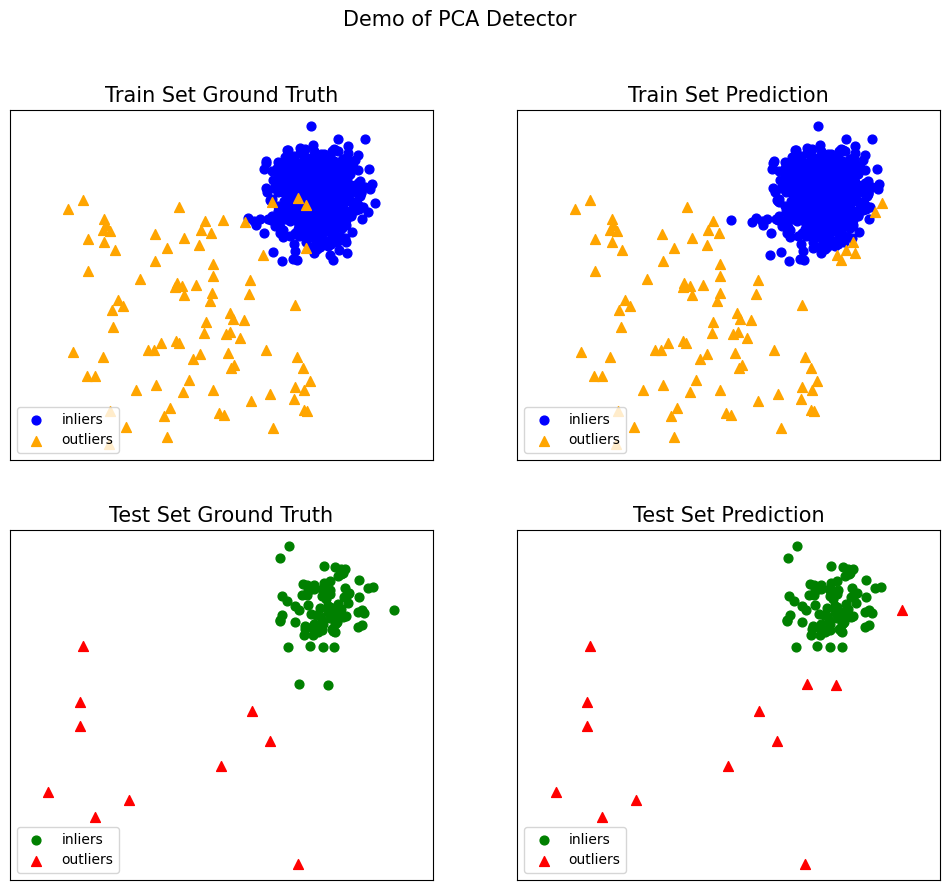

Process took 0.09087514877319336 seconds.


In [2]:
# Configuration
PRINT_MODEL_INFO = False                              # Set this to True to print the PCA model details

start = time.time()
if __name__ == "__main__":
    contamination = 0.1                              # Percentage of outliers
    n_train = 900                                    # Number of training points
    n_test = 100                                     # Number of testing points

    # Generate synthetic data
    X_train, X_test, y_train, y_test = generate_sample_data(
        n_train=n_train, n_test=n_test, n_features=2, contamination=contamination, random_state=0
    )

    # Initialize the PCA detector
    pca = PCA(
        contamination=contamination,
        n_components=0.95,                    # Retain 95% of variance
        whiten=False,                         # Do not whiten components
        svd_solver='auto',                    # Automatically select SVD solver
        random_state=42
    )

    # Train the PCA model
    pca.fit(X_train)
    
    if PRINT_MODEL_INFO:
        print(pca)                                # Print the PCA model details
         
    # Get predictions
    y_train_pred = pca.predict(X_train)
    y_test_pred = pca.predict(X_test)
    
    # Get outlier scores
    y_train_scores = pca.decision_function(X_train)
    y_test_scores = pca.decision_function(X_test)

    # Evaluate the model
    evaluate_model('PCA', y_train, y_train_scores, y_test, y_test_scores)

    # Visualize the results
    visualize_results('PCA', X_train, y_train, X_test, y_test, y_train_pred, y_test_pred)

end = time.time()

print(f"Process took {end - start} seconds.")

## Real-World Example

We will use the heart disease dataset, the same dataset used in the previous algorithm examples. For more details on the dataset, you can refer to the [ABOD algorithm notebook](03-abod-algorithm.ipynb) or visit [this link](https://www.dbs.ifi.lmu.de/research/outlier-evaluation/DAMI/semantic/HeartDisease/HeartDisease_44.html).

### PCA-Based Outlier Detection (PCA-OD) Workflow

To effectively leverage the PCA (Principal Component Analysis) algorithm for outlier detection, follow these comprehensive steps:

1. **Data Preprocessing**:
   - **Handle Missing Data**: Impute or remove missing values to ensure the dataset's integrity.
   - **Eliminate Duplicates**: Remove duplicate entries to prevent bias in the outlier detection process.
   - **Encode Categorical Features**: Convert categorical variables into numerical format using techniques such as one-hot encoding or label encoding.
   - **Scale Features**: Normalize or standardize features to ensure a uniform scale across all input variables. This step is particularly important for PCA as it relies on variance.
   - **Dimensionality Reduction**: The PCA algorithm itself performs dimensionality reduction, which is integral when dealing with high-dimensional data. The number of components is typically chosen to retain a high percentage of the variance, such as 95%.

2. **Applying the PCA Detector**:
   - **Initialize the PCA Model**: Set up the PCA detector, specifying parameters such as the number of components (`n_components`) to retain.
   - **Train the Model**: Fit the PCA model to the preprocessed data. The model will transform the data into a lower-dimensional space and assess how well each point fits into this space, identifying outliers as those that deviate significantly from the expected variance.
   - **Prediction**: Use the trained PCA model to predict outliers in the dataset by evaluating the reconstruction error or the anomaly scores based on the principal components.

3. **Performance Evaluation**:
   - **Compute Metrics**: Evaluate the performance of the PCA model using metrics such as:
     - Precision
     - ROC AUC (Area Under the Receiver Operating Characteristic Curve)
     - Average Precision
   - **Cross-Validation**: Implement k-fold cross-validation to ensure robust performance assessment.

4. **Result Analysis and Interpretation**:
   - **Visualize Outliers**: Generate scatter plots or other visualizations to represent detected outliers visually. This may include visualizing the first two principal components and highlighting the outliers.
   - **Analyze Outlier Characteristics**: Identify common features or patterns among the detected outliers, particularly in how they differ from the main distribution of data.
   - **Domain-Specific Interpretation**: Contextualize the detected outliers within the specific domain of the dataset, understanding why certain points might be considered outliers.
   - **Comparative Analysis**: Compare the PCA model's results with traditional single-algorithm approaches or other outlier detection methods if applicable.

5. **Model Refinement**:
   - **Hyperparameter Tuning**: Adjust the PCA model's parameters, such as the number of components or the percentage of variance retained, based on the initial results to improve performance.
   - **Method Adjustment**: Experiment with different ways of evaluating outliers, such as using the reconstruction error or leveraging robust PCA methods.

> **Note**:  
> To reproduce the results in the following example, ensure you have downloaded the required dataset and saved it in an accessible directory. Additionally, verify that all necessary libraries and dependencies are installed in your environment.

### Configuring the PCA Detector

In this example, I will configure the PCA model with the following parameters to detect outliers:

- **Number of Components**: 
  - `n_components=0.95` to retain 95% of the variance in the data.
- **Whitening**: 
  - `False` as whitening the data is not necessary for this task.
- **SVD Solver**: 
  - `'auto'` to let the model automatically choose the best algorithm for SVD computation.
- **Random State**: 
  - `42` to ensure reproducibility of the results.

In [3]:
# Import utility functions
from data_utils import *       # This module is in the same directory as the notebooks. Ensure to have to reproduce this
                               # code chunk results (Feel free to change the placement of this module
                               # but ensure to add it the system path)


PRINT_MODEL_INFO = False

if __name__ == "__main__":
    # Load the dataset
    DATA_PATH = "../../datasets/HeartDisease/HeartDisease_withoutdupl_norm_44.arff"
    df = load_arff_data(DATA_PATH)

    # Preprocess the dataset
    X, y = preprocess_heart_disease_data(df, target_name='outlier', scale=True)

    # Optionally split the dataset if needed (although for unsupervised learning, this may not be required)
    X_train, X_test, y_train, y_test = stratify_split_data(X, y, test_size=0.1, random_state=42)

    # Initialize the PCA detector
    pca = PCA(
        contamination=0.4444,                 # Set the expected proportion of outliers
        n_components=2,                       # Number of principal components to use
        whiten=False,                         # Whitening is not necessary for outlier detection
        svd_solver='auto',                    # Solver to use for the SVD calculation
        random_state=42
    )

    # Train the PCA model
    pca.fit(X_train)

    if PRINT_MODEL_INFO:
        print(pca)  # Print the PCA model summary

    # Get predictions
    y_train_pred = pca.predict(X_train)
    y_test_pred = pca.predict(X_test)
    
    # Get outlier scores
    y_train_scores = pca.decision_function(X_train)
    y_test_scores = pca.decision_function(X_test)

    # Evaluate the model
    evaluate_model('PCA', y_train_pred, y_train_scores, y_test_pred, y_test_scores)

    # Print the indices of the detected outliers
    outlier_indices = np.where(y_test_pred == 1)[0]
    print("Indices of the outliers:")
    print(outlier_indices)

    # Slice the data to have only the outliers
    outliers_only = X_test[outlier_indices, :]
    print(f"Number of detected outliers: {outliers_only.shape[0]}")

Training set class distribution: Counter({np.int64(0): 135, np.int64(1): 108})
Test set class distribution: Counter({np.int64(0): 15, np.int64(1): 12})
y_train has multiple classes: {np.int64(0), np.int64(1)}
y_test has multiple classes: {np.int64(0), np.int64(1)}

On Training Data:
PCA ROC:1.0, precision @ rank n:1.0

On Test Data:
PCA ROC:1.0, precision @ rank n:1.0
Indices of the outliers:
[ 0  7  8  9 10 11 12 13 15 17 18 19 24 25]
Number of detected outliers: 14


## Training Principal Component Analysis (PCA) for Unsupervised Outlier Detection

In this section, we’ll demonstrate how to train the Principal Component Analysis (PCA) model for unsupervised outlier detection. PCA is a powerful tool for reducing the dimensionality of data while retaining the most important features. In the context of outlier detection, PCA helps in identifying anomalies by analyzing the variance in the data and flagging those instances that do not conform to the principal components of the dataset.

### Workflow Overview

1. **Data Preparation**:
    - We begin by loading and preprocessing the dataset. Since this is an unsupervised task, there is no need for labeled data.
    - The entire dataset will be used to train the PCA model, allowing it to capture the key variance in the data and identify deviations that indicate outliers.

2. **Model Initialization**:
    - We initialize the PCA model with the desired number of principal components (`n_components`) to capture the variance in the dataset.
    - The model is configured to project the data into a lower-dimensional space where the principal components represent the directions of maximum variance.

3. **Training the PCA Model**:
    - The PCA model is trained on the entire dataset. During training, the model computes the principal components and projects the data onto these components.
    - Data points that exhibit low reconstruction scores or high reconstruction errors (i.e., the difference between the original data and its projection) are flagged as potential outliers.

4. **Outlier Detection**:
    - After training, the model predicts which instances in the dataset are outliers based on their reconstruction errors.
    - Instances with high reconstruction errors are considered outliers as they do not conform well to the principal components that capture the main data variance.

5. **Results Analysis**:
    - We will analyze the detected outliers by reviewing their characteristics and understanding how they differ from the inliers in terms of their projection onto the principal components.
    - Visualization techniques, such as plotting the principal components and reconstruction errors, will be employed to illustrate the separation between inliers and outliers, providing insights into the model’s effectiveness.

(270, 14)
(270,)
outlier
no     150
yes    120
Name: count, dtype: int64
120
************************************************************************
                        Training and Prediction                         
************************************************************************
************************************************************************
                         Displaying Information                         
************************************************************************
Outliers detected: 120 out of 270
Indices of the outliers:
[  0   1   3   4   6   8   9  11  13  15  16  17  18  19  20  24  29  31
  33  35  37  43  44  45  46  48  49  51  52  53  56  57  58  59  60  63
  64  67  70  71  72  73  74  75  77  85  86  87 101 103 107 110 112 113
 117 118 119 121 122 123 126 129 130 133 135 138 144 145 153 156 159 160
 165 167 169 170 171 172 174 175 176 178 180 181 184 187 188 189 191 194
 198 199 205 209 210 211 213 214 223 224 226 227 228 229 230 

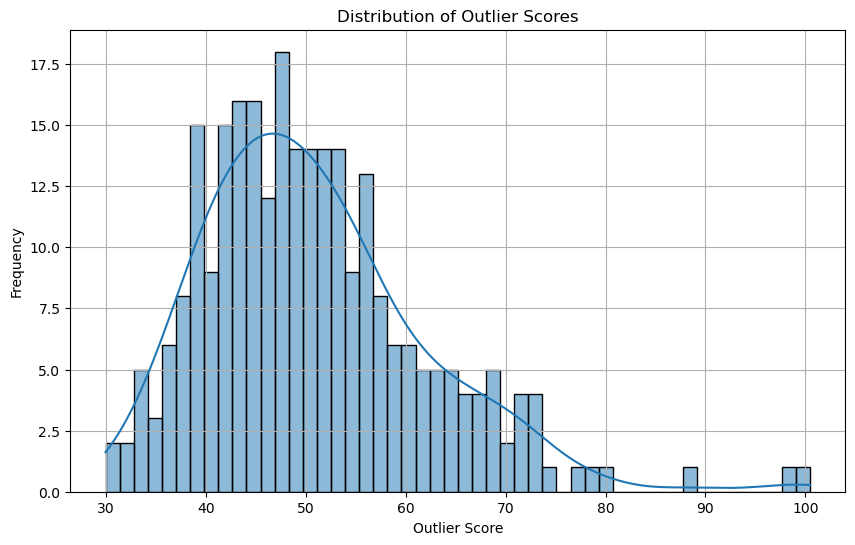

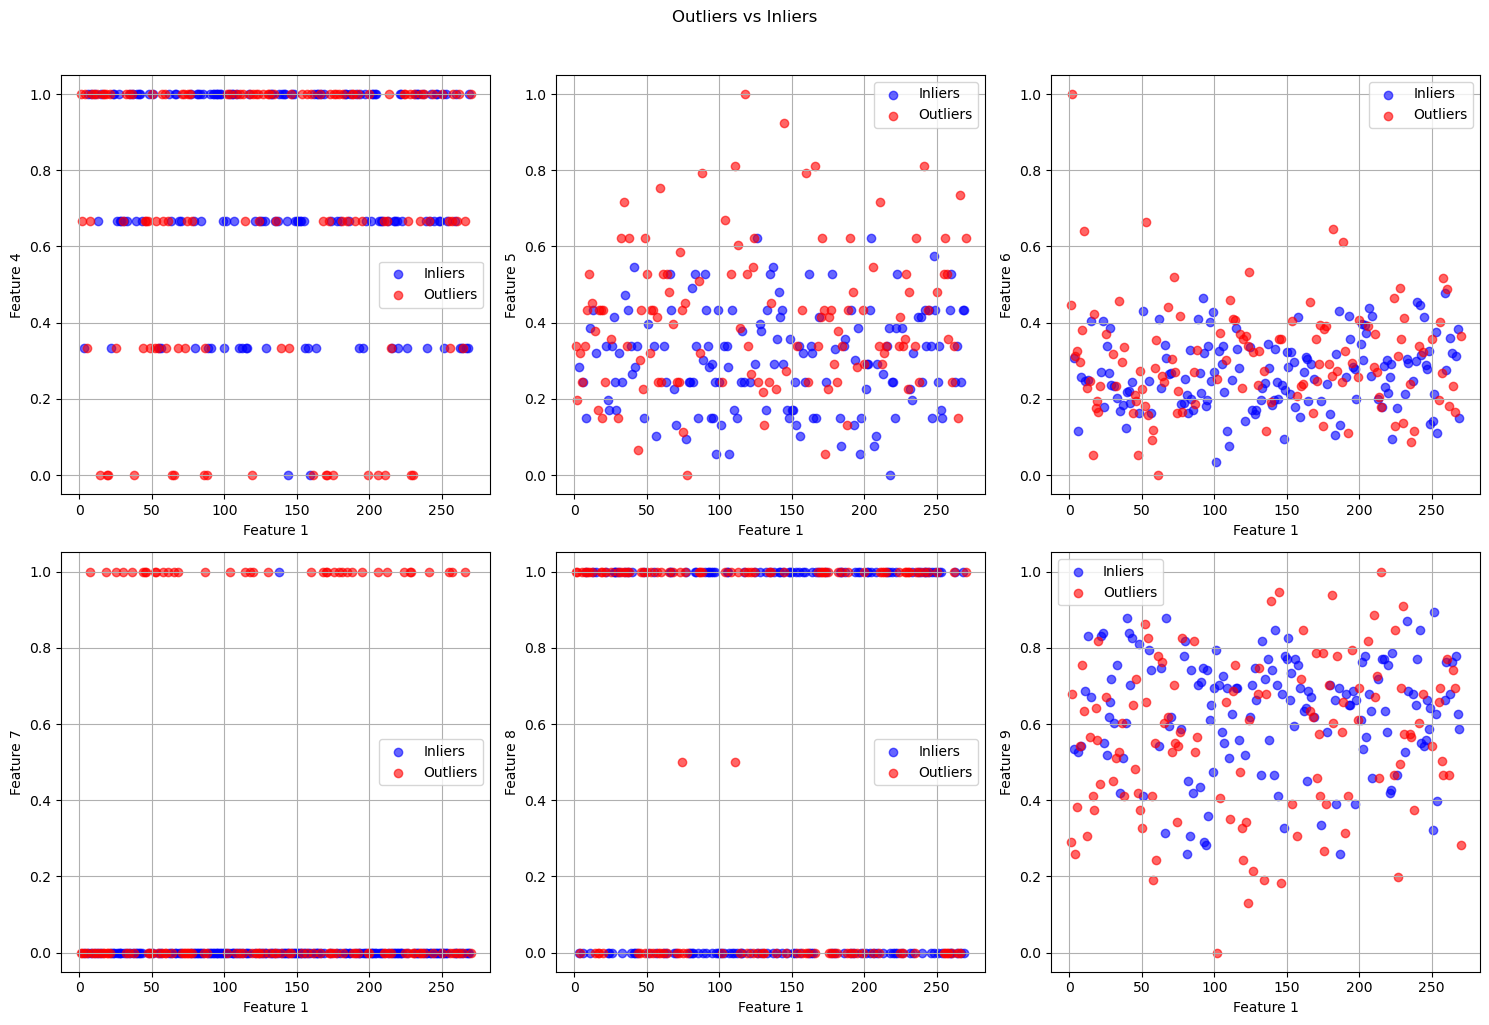

In [4]:
# Load and preprocess the dataset
df = load_arff_data(DATA_PATH)
X, y = preprocess_heart_disease_data(df, 'outlier')

print(X.shape)
print(y.shape)
print(df['outlier'].value_counts())
print(sum(y == 1))

# Initialize the PCA model
pca = PCA(
    contamination=0.4444,  
    n_components=2,             # Number of principal components to keep 
    whiten=True,                # Whitening to remove correlation among features
    random_state=0              # Ensuring reproducibility
)

# Train the PCA model
pca.fit(X)

print_banner("*", 72, "Training and Prediction")

# Get predictions
y_pred = pca.labels_  # binary labels (0: inliers, 1: outliers)
outlier_scores = pca.decision_scores_  # raw outlier scores

print_banner("*", 72, "Displaying Information")
# You can now analyze the results
print(f"Outliers detected: {sum(y_pred)} out of {len(y_pred)}")

# Getting the outlier indexes
outlier_indices = np.where(y_pred == 1)[0]

# Print the indexes of the outliers
print("Indices of the outliers:")
print(outlier_indices)

# Slice the data to have only the outliers
outliers_only = X.iloc[outlier_indices, :]
print(outliers_only.shape[0])

print_banner("*", 72, "Plotting")

# Plot the distribution of outlier scores
plt.figure(figsize=(10, 6))
sns.histplot(outlier_scores, bins=50, kde=True)
plt.title("Distribution of Outlier Scores")
plt.xlabel("Outlier Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plot outlier scores against selected features
plot_outliers_vs_inliers(X, y_pred=y_pred, plot_features=[3, *range(4, 9)])

---

### Fine-Tune PCA Algorithm

In this section, we will fine-tune the hyperparameters for the PCA Outlier Detector. Specifically, we will focus on finding the optimal number of components (i.e., `n_components`) that maximizes the model's performance. Since we have prior information about the number of outliers, the best `n_components` will be determined based on the `precision at rank n` metric.

We will be using the `hyperopt` package to find the best hyperparameters. It is assumed that you already have a background in hyperparameter tuning techniques, as they are beyond the scope of this notebook tutorial.

In [5]:
from utils import precision_n_scores

# Fine-tune the PCA algorithm using the Hyperopt framework
# ===============================================

# Known contamination rate
contamination = 0.4444

# Number of outliers
n_outliers = int(contamination * len(y))

# The search space for n_components
search_space = {
    'n_components': scope.int(hp.quniform('n_components', 2, min(X.shape[1], 50), 1)),
    'whiten': hp.choice('whiten', [True, False])
}

def hyperopt_objective(params, X, y, n_outliers, contamination):
    """
    Objective function for Hyperopt to optimize the n_components and whiten parameters of PCA.

    Parameters
    ----------
    params : dict
        Dictionary containing the hyperparameters 'n_components' and 'whiten'.

    X : ndarray
        The feature matrix.

    y : ndarray
        The true labels.

    n_outliers : int
        The number of true outliers.

    contamination : float
        The contamination rate (proportion of outliers).

    Returns
    -------
    dict
        Dictionary containing the loss (negative precision at rank n) and the status.
    """
    n_components = params['n_components']
    whiten = params['whiten']

    pca = PCA(n_components=n_components, whiten=whiten, contamination=contamination)

    # Fit the model to the data
    pca.fit(X)

    # Predict the outlier scores
    outlier_scores = pca.decision_scores_

    # Calculate precision at rank n
    precision_n = precision_n_scores(y, outlier_scores, n=n_outliers)

    return {'loss': -precision_n, 'status': STATUS_OK}


# Use Hyperopt to optimize the n_components and whiten parameters
trials = Trials()
best = fmin(fn=lambda params: hyperopt_objective(params, X_train, y_train, n_outliers, contamination),
            space=search_space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(f"Best n_components: {best['n_components']}")
print(f"Best whiten: {bool(best['whiten'])}")

100%|██████████| 100/100 [00:00<00:00, 503.34trial/s, best loss: -0.6386554621848739]
Best n_components: 2.0
Best whiten: True


> **Note**
In the previous example, it appears we selected the most optimal parameters for our model. While the heart disease dataset is relatively small and primarily used for illustrative purposes, real-world applications often involve more complex datasets. In such cases, fine-tuning and adjusting the algorithms becomes essential for achieving the best results.

---

## PCA in Practice

In this section, we will demonstrate the application of the PCA algorithm on various benchmark datasets across different domains:

1.	**Computer Vision Dataset**: The well-known MNIST dataset.
2.	**Text Analysis Dataset**:   Amazon Reviews dataset.
3.	**Network Intrusion Detection Dataset**: An intrusions simulated dataset in a military network environment. 

**To do** 

`...` This section will be written later `...`

In [6]:
mnist_path = "../../datasets/Classical/24_mnist.npz"
mnist = np.load(mnist_path, allow_pickle=True)
X, y = mnist['X'], mnist['y']

print(X.shape)
print(y.shape)
print(np.count_nonzero(y)/len(y))

(7603, 100)
(7603,)
0.09206892016309351


In [7]:
amazon_path = "../../datasets/NLP_by_BERT/amazon.npz"
amazon = np.load(amazon_path, allow_pickle=True)
X, y = amazon['X'], amazon['y']

print(X.shape)
print(y.shape)
print(np.count_nonzero(y)/len(y))

(10000, 768)
(10000,)
0.05


In [8]:
## Load Intrusion datasets
train = pd.read_csv("../../datasets/networkIntrosion/Train_data.csv")
test = pd.read_csv("../../datasets/networkIntrosion/Test_data.csv")

print(train.shape)
# print(train.info())

(25192, 42)


In [9]:
print(test.shape)
# print(test.info())

(22544, 41)


In [10]:
# Check the `class` which is the target
print(train.loc[:, "class"].value_counts())

class
normal     13449
anomaly    11743
Name: count, dtype: int64


In [11]:
# Identify categorical and numerical columns
categorical_cols = [col for col in train.columns.to_list() if train[col].dtype=='object' and col !='class']
numerical_cols = [col for col in train.columns if col not in categorical_cols and col !='class']

# Prepare the data
X_train = train.drop(columns=['class']) 
y_train = train['class'].apply(lambda x: 1 if x == 'anomaly' else 0) 

# The X_test
X_test = test

In [12]:
# Apply preprocessing


In [13]:
# Apply KNN

In [14]:
# Visualize the results


## Conclusion

This notebook demonstrates the application of the **Principal Components Analysis Outlier Detector (PCA-OD)** algorithm across multiple contexts. Through theoretical exploration and practical implementation, we have showcased KNN's strengths in detecting anomalies in both artificial and real-world datasets.